# IMPORT

In [19]:
%matplotlib inline
# LOAD SYSTEM MODULES
import sys
import json
from operator import itemgetter

# LOAD 3RD PARTY MODULES
import pymongo
import ottype
import psycopg2
import matplotlib.pyplot as plt
import numpy as np

# LOAD CUSTOM MODULES
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/suinkim/elice/elice-research/2016_intermediate_code/config.py'>

# CONNECT TO DATABASE

In [12]:
def mongodb_connect():
    # CONNECT TO MONGODB
    client = pymongo.MongoClient('mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1' % \
                                 (config.MONGODB['user'],
                                  config.MONGODB['password'],
                                  config.MONGODB['host'],
                                  config.MONGODB['db']), config.MONGODB['port'])
    db = client.elice

    print("=== Collections ===")
    print("\n".join(db.collection_names()))

    return db

def postgres_connect():
    # CONNECT TO POSTGRESQL
    conn = psycopg2.connect("host='%s' dbname='%s' user='%s' password='%s'" % \
                            (config.POSTGRES['host'],
                             config.POSTGRES['db'],
                             config.POSTGRES['user'],
                             config.POSTGRES['password']))
    cur = conn.cursor()

    return cur

In [13]:
elice_mongo = mongodb_connect()
elice_postgres = postgres_connect()

=== Collections ===
exercise_running.outputs
usercode_share.docs
attachments.files
attachments.chunks
usercode_share.ops
attachments.metafiles


# DEFINE GLOBAL VARIABLES

In [14]:
user_typed_keystrokes = {}

# FETCH LECTURES

In [22]:
def fetch_metadata(elice_postgres, course_id):
    # FETCH LECTURES
    elice_postgres.execute("""SELECT * FROM LECTURE_MODEL
                              WHERE COURSE_ID = %d AND IS_DELETED = False
                              ORDER BY ID""" % \
                           (course_id))
    lectures = []
    for lecture in elice_postgres.fetchall():
        lecture_id = lecture[2]
        lecture_title = lecture[4]
        # ONLY GET HOMEWORKS
        if 'homework' not in lecture_title.lower(): continue
        print("%d: %s" % (lecture_id, lecture_title))
        lectures.append(lecture)

    # LECTURES AND MATERIAL EXERCISES
    lecture_materials = []

    # FETCH MATERIAL EXERCISES
    for lecture in lectures:
        lecture_id = lecture[2]
        elice_postgres.execute("""SELECT material_exercise_model.id, material_exercise_model.title FROM material_exercise_model
                                  INNER JOIN lecture_page_order_model
                                  ON material_exercise_model.lecture_page_order_id = lecture_page_order_model.id
                                  WHERE lecture_page_order_model.lecture_id = %d
                                  AND material_exercise_model.is_deleted = False
                                  ORDER BY lecture_page_order_model.order_no ASC""" % \
                                  (lecture_id))

        # LIST OF DICTIONARIES
        exercises = [{'id': x[0], 'title': x[1]} for x in elice_postgres.fetchall()]

        # MATERIAL EXERCISES FOR LECTURE_ID
        lecture_materials.append({'id': lecture_id,
                                  'title': lecture[4],
                                  'exercises': exercises})

    print(lecture_materials)
    return lecture_materials

In [23]:
config.COURSE

{'course_id': 7, 'lecture_id': 58, 'material_exercise_id': 305}

In [24]:
lecture_materials = fetch_metadata(elice_postgres, course_id=config.COURSE['course_id'])

45: Homework 1
57: Homework 2
68: Homework 3
84: Homework 4
94: Homework 5
[{'title': 'Homework 1', 'id': 45, 'exercises': [{'title': "Task1: 'HELLO' in a plain world", 'id': 227}, {'title': "Task2: 'HELLO' in a random world", 'id': 228}]}, {'title': 'Homework 2', 'id': 57, 'exercises': [{'title': 'Task1: Linear-graph', 'id': 359}, {'title': 'Task2: Four-degree-polynomial-graph', 'id': 362}, {'title': 'Task3: Ellipse-graph', 'id': 361}]}, {'title': 'Homework 3', 'id': 68, 'exercises': [{'title': 'Task1 : Answer a question whose words are ordered correctly', 'id': 386}, {'title': 'Task2: Answer a question whose words are randomly shuffled', 'id': 387}, {'title': 'Task3: Answer a question whose words are randomly shuffled, lost and reversed', 'id': 388}, {'title': 'Task4: Answer a question whose words are randomly shuffled, lost and corrupted', 'id': 389}]}, {'title': 'Homework 4', 'id': 84, 'exercises': [{'title': 'HW4 How to Control Hubo Like a Pro', 'id': 418}]}, {'title': 'Homework 5

# FETCH DOCUMENT HISTORY

In [25]:
def fetch_docs(elice_mongo, elice_postgres, lecture_id, material_exercise_id):
    # FILTER BY MATERIAL EXERCISE IDS
    usercode_docs = elice_mongo['usercode_share.docs'].find({
                        'material_exercise_id': material_exercise_id
                    })
    
    for doc in usercode_docs:
        user_id = doc['owner_id']
        
        user_typed_keystrokes.setdefault(user_id, {})
        fetch_ops(elice_mongo, doc, lecture_id, user_id)

In [26]:
def fetch_ops(elice_mongo, doc, lecture_id, user_id): #, user_commits, lecture_id, material_exercise_id, user_id):
    # FILTER BY DOCUMENT OBJECT ID
    ops = elice_mongo['usercode_share.ops'].find({
            'doc_id': doc['_id']
          })
    
    user_typed_keystrokes[user_id].setdefault(lecture_id, [])
    
    content = doc['content']
    for op in ops:
        striped_op = op['op']
        version = op['version']
        version_timestamp = op['created_timestamp']

        user_typed_keystrokes[user_id][lecture_id].append({
                'doc_id': doc['_id'],
                'version': op['version'],
                'timestamp': version_timestamp,
                'op': striped_op,
                'filename': doc['filename'],
            })

# RUN

In [28]:
user_typed_keystrokes = {}
for lecture in lecture_materials:
    print("Lecture %d: %s" % (lecture['id'], lecture['title']))
    for exercise in lecture['exercises']:
        print("  exercise %d: %s" % (exercise['id'], exercise['title']))
        fetch_docs(elice_mongo, 
                   elice_postgres, 
                   lecture['id'], 
                   exercise['id'])

Lecture 45
  exercise 227
  exercise 228
Lecture 57
  exercise 359
  exercise 362
  exercise 361
Lecture 68
  exercise 386
  exercise 387
  exercise 388
  exercise 389
Lecture 84
  exercise 418
Lecture 94
  exercise 442


# CALCULATE TYPING SPEED

In [29]:
ops_speeds = {}

In [31]:
session_cutoff = 1000 * 60 * 10 # 10 mins

for user_id in user_typed_keystrokes:
    ops_speeds[user_id] = {}
    for lecture_id in user_typed_keystrokes[user_id]:
        ops_speeds[user_id][lecture_id] = []
        
        operations = user_typed_keystrokes[user_id][lecture_id]
        
        operation_timestamps = [x['timestamp'] for x in operations]
        operation_timestamps = sorted(operation_timestamps)
        
        for i in range(0, len(operation_timestamps) - 1):
            difference = operation_timestamps[i + 1] - operation_timestamps[i]

            char_diff = 0
            num_ops = 0
            
            for single_op in operations[i + 1]['op'][1:]:
                if isinstance(single_op, str):
                    char_diff += len(single_op)
                elif isinstance(single_op, dict):
                    char_diff += len(single_op['d'])
                num_ops += 1

            if char_diff > 20:
                continue
            if num_ops == 0:
                continue
        
            difference /= num_ops
            
            if difference < session_cutoff:
                for j in range(num_ops):
                    ops_speeds[user_id][lecture_id].append(difference)

# VISUALIZE

In [32]:
ops_average_speed = {}

for user_id in ops_speeds:
    if user_id < 0:
        continue
    
    for lecture_id in ops_speeds[user_id]:
        avg_diff = np.mean(ops_speeds[user_id][lecture_id])
        if np.isnan(avg_diff):
            continue
        
        ops_average_speed.setdefault(lecture_id, [])
        ops_average_speed[lecture_id].append(60000 / avg_diff)

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


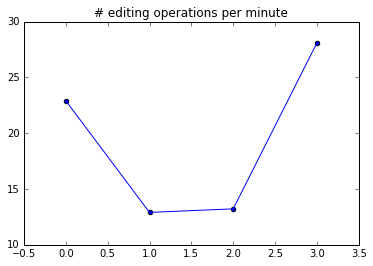

In [33]:
X = sorted(ops_average_speed.keys())
y_mean = [np.mean(ops_average_speed[x]) for x in X]

plt.plot(y_mean)
plt.scatter(range(len(y_mean)), y_mean)
#plt.errorbar(range(len(y_mean)), y_mean, yerr=[np.std(ops_average_speed[x]) for x in X])
plt.title('# editing operations per minute')

# BYTES EDITED PER SEC

In [34]:
bps = {}

session_cutoff = 1000 * 60 * 10 # 10 mins

for user_id in user_typed_keystrokes:
    bps[user_id] = {}
    for lecture_id in user_typed_keystrokes[user_id]:
        bps[user_id][lecture_id] = []
        
        operations = user_typed_keystrokes[user_id][lecture_id]
        
        for i in range(1, len(operations)):
            op = operations[i]
            op_before = operations[i - 1]
            striped_op = op['op'][1:]
            time_diff = - (op['timestamp'] - op_before['timestamp'])
            char_diff = 0
            
            for single_op in striped_op:                
                if isinstance(single_op, str):
                    char_diff += len(single_op)
                elif isinstance(striped_op, dict):
                    char_diff += len(single_op['d'])
                    
            if char_diff > 10:
                continue
            
            bps[user_id][lecture_id].append(1000 * char_diff / time_diff)

In [35]:
ops_average_speed = {}

for user_id in ops_speeds:
    if user_id < 0:
        continue
    
    for lecture_id in ops_speeds[user_id]:
        eps = np.mean(bps[user_id][lecture_id])
        if np.isnan(eps):
            continue
        
        ops_average_speed.setdefault(lecture_id, [])
        ops_average_speed[lecture_id].append(60 * eps)

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


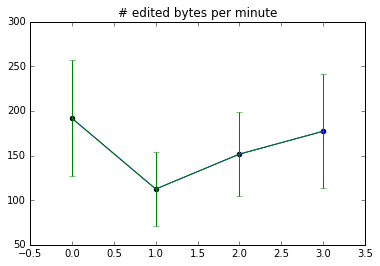

In [36]:
X = sorted(ops_average_speed.keys())
y_mean = [np.mean(ops_average_speed[x]) for x in X]

plt.plot(y_mean)
plt.scatter(range(len(y_mean)), y_mean)
plt.errorbar(range(len(y_mean)), y_mean, yerr=[np.std(ops_average_speed[x]) for x in X])
plt.title('# edited bytes per minute')